# Combining Classifiers

Trevor Holland

This notebook should have been the proof-of-concept building the algorithms and classes that I would use on more complicated datasets. For this notebook, I'm using the MNIST dataset because it's a classifer that is easily recognizable, small enough to download, and unpacks into a training/validate/test split in two lines.

In [1]:
import neuralnetworks as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import copy
import pickle
import gzip
import time

Unpacking MNIST.

In [2]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

This is a standard confusion matrix. It looks a lot like the one I found in wikipedia, but also like the ones from the various lectures and assignments from cs445. I copied it out of one of my homework assignments and do not know if I wrote it or if it came with the assignment.

In [3]:
def confusion_matrix(predicted_classes, actual_classes):
    classifiers = np.unique(actual_classes)
    table = []
    for true_class in classifiers:
        row = []
        for predicted_class in classifiers:
            row.append(100 * np.mean(predicted_classes[actual_classes == true_class] == predicted_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=classifiers, columns=classifiers)
    return conf_matrix

## Simple Classifier

Here I'm unpacking the training, validation, and test MNIST sets into inputs (X) and targets (T) for training classifiers.

In [4]:
Xtrain = train_set[0]
Ttrain = train_set[1]

Xval = valid_set[0]
Tval = valid_set[1]

Xtest = test_set[0]
Ttest = test_set[1]

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)
print(Ttrain[0])

(50000, 784) (50000,) (10000, 784) (10000,) (10000, 784) (10000,)
5


This reshapes each image into a 28 by 28 matrix instead of a 1 by 784 vector. This is a basic reshaping of a two dimensional image from the single line of data that represents it.

In [5]:
Xtrain_cnn = Xtrain.reshape(-1, 1, 28, 28)
Xval_cnn = Xval.reshape(-1, 1, 28, 28)
Xtest_cnn = Xtest.reshape(-1, 1, 28, 28)
print(Xtrain_cnn.shape, Xval_cnn.shape,  Xtest_cnn.shape)

(50000, 1, 28, 28) (10000, 1, 28, 28) (10000, 1, 28, 28)


Using the GPUs to improve overall performance of the neural networks.

In [6]:
device = 'cpu'
if torch.cuda.is_available():
    y_or_n = input('Would you like to run on the GPU? (y or n): ')
    if y_or_n == 'y' or y_or_n == 'yes':
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on', device)

Running on cuda:0


This is a convolutional neural network that does really well with the MNIST data set. It does so well that I couldn't improve on its accuracy with smaller, specialized neural networks.

In [7]:
cnnet = nn.ConvNet(28 * 28,
                [10, 10], # n_hiddens_per_conv_layer
                [10], # n_hiddens_per_fc_layer
                10,
                patch_size_per_conv_layer=[5, 5], stride_per_conv_layer=[2, 2], device=device)
cnnet.to(device)

start_time = time.time()
n_epochs = 50
batch_size = 1000
learning_rate = 0.001
cnnet.train(Xtrain_cnn, Ttrain, batch_size, n_epochs, learning_rate, method='adam')
elapsed_time = time.time() - start_time

print(f'Took {elapsed_time} seconds to train full network')

adam: Epoch 5 Loss 0.742
adam: Epoch 10 Loss 0.377
adam: Epoch 15 Loss 0.237
adam: Epoch 20 Loss 0.172
adam: Epoch 25 Loss 0.136
adam: Epoch 30 Loss 0.113
adam: Epoch 35 Loss 0.097
adam: Epoch 40 Loss 0.086
adam: Epoch 45 Loss 0.077
adam: Epoch 50 Loss 0.069
Took 22.204264879226685 seconds to train full network


The confusion matrix shows that most things are getting identified with greater than 96% accuracy. There's not a lot of room for improvement here, but none of them are 100% and there's some room to try to improve the time it takes to train.

In [8]:
Y_classes, Y_probs = cnnet.use(Xtest_cnn)
confusion_matrix(Y_classes, Ttest).style.background_gradient(cmap='Blues').format("{:.1f} %")

,0,1,2,3,4,5,6,7,8,9
0,98.5 %,0.0 %,0.4 %,0.0 %,0.3 %,0.0 %,0.2 %,0.2 %,0.2 %,0.2 %
1,0.0 %,99.1 %,0.3 %,0.1 %,0.0 %,0.1 %,0.0 %,0.1 %,0.4 %,0.0 %
2,0.3 %,0.2 %,98.4 %,0.2 %,0.1 %,0.0 %,0.0 %,0.3 %,0.5 %,0.0 %
3,0.0 %,0.0 %,0.3 %,98.2 %,0.0 %,0.4 %,0.0 %,0.4 %,0.7 %,0.0 %
4,0.0 %,0.0 %,0.1 %,0.1 %,98.0 %,0.0 %,0.4 %,0.0 %,0.0 %,1.4 %
5,0.3 %,0.0 %,0.0 %,1.6 %,0.0 %,96.0 %,0.2 %,0.1 %,1.0 %,0.8 %
6,0.3 %,0.1 %,0.2 %,0.0 %,0.5 %,1.0 %,97.4 %,0.0 %,0.4 %,0.0 %
7,0.1 %,0.3 %,1.0 %,0.8 %,0.0 %,0.0 %,0.0 %,96.8 %,0.2 %,0.9 %
8,0.6 %,0.0 %,0.3 %,0.3 %,0.2 %,0.3 %,0.0 %,0.5 %,97.6 %,0.1 %
9,0.4 %,0.2 %,0.0 %,1.1 %,0.3 %,0.4 %,0.0 %,0.5 %,0.3 %,96.8 %


Collecting up all of the elements from the training set that were wrong to try to figure out the threshold for the probabilities. The bad pairs are the two elements that were mistaken. Counting up which elements were misidentified should help in figuring out which specialty networks to train.

In [9]:
Y_train_classes, Y_train_probs = cnnet.use(Xtrain_cnn)

This creates a tuple from two elements, ordering it so that the smaller value is always first in the tuple. Then it goes through the training classifications and the training targets to find the elements that were wrong.

In [10]:
def tuplefyOrderedPair(x, y):
    if x < y:
        return (x, y)
    else:
        return (y, x)

wrongs = {}
bad_pairs = {}
for i in range(Ttest.shape[0]):
    if Y_train_classes[i] != Ttrain[i]:
        wrongs.update({i:max(Y_train_probs[i])})
        pair = tuplefyOrderedPair(Y_train_classes[i], Ttrain[i])
        if pair in bad_pairs:
            bad_pairs.update({pair: bad_pairs[pair]+1})
        else:
            bad_pairs.setdefault(pair, 1)

print({k: v for k, v in sorted(wrongs.items(), key=lambda item: item[1])})
print(bad_pairs)

{6269: 0.27839765, 1165: 0.28322762, 1364: 0.33009383, 4153: 0.33100557, 5174: 0.3433973, 3510: 0.3490948, 2676: 0.3558752, 5691: 0.3590338, 1324: 0.36476842, 8883: 0.36655575, 5103: 0.36797512, 444: 0.37196466, 3814: 0.37591013, 3056: 0.37717584, 5065: 0.37772024, 1075: 0.382845, 4600: 0.38796544, 718: 0.39003053, 6418: 0.3926025, 3512: 0.39857143, 6197: 0.39991245, 4156: 0.4001133, 788: 0.404635, 8904: 0.40731013, 8940: 0.42272392, 9727: 0.4323332, 3810: 0.4369039, 1512: 0.43937385, 7074: 0.44329342, 3436: 0.4492829, 5057: 0.4537266, 8268: 0.46508506, 854: 0.46603563, 5013: 0.46665925, 517: 0.4670925, 9098: 0.46788928, 1021: 0.4758728, 4666: 0.47630417, 4945: 0.4774048, 4590: 0.47908595, 9344: 0.4854836, 892: 0.492873, 3998: 0.49552718, 4762: 0.49595678, 995: 0.49661806, 1375: 0.49829897, 4322: 0.49994445, 1244: 0.5007465, 2098: 0.5012209, 4958: 0.502032, 6486: 0.5053558, 5798: 0.50624675, 1137: 0.5070511, 7270: 0.5082915, 4458: 0.51380324, 8202: 0.52018493, 2490: 0.52873385, 80: 0.5

Listing out the most confused pairs of numbers to see if that's a useful reduction in the number of smaller neural networks to train.

In [11]:
asc_bad_pairs = {k: v for k, v in sorted(bad_pairs.items(), key=lambda item: item[1])}
print(asc_bad_pairs)

{(8, 9): 1, (2, 5): 1, (2, 6): 1, (0, 2): 1, (5, 7): 1, (6, 8): 1, (3, 4): 1, (0, 7): 1, (0, 4): 1, (1, 4): 1, (4, 8): 1, (0, 8): 1, (1, 6): 1, (4, 5): 2, (0, 3): 2, (1, 9): 2, (1, 3): 3, (4, 7): 3, (7, 8): 3, (0, 5): 3, (3, 8): 4, (1, 8): 4, (5, 9): 4, (4, 6): 4, (0, 6): 5, (0, 9): 5, (5, 8): 6, (2, 7): 7, (2, 8): 7, (3, 7): 7, (1, 7): 8, (1, 2): 9, (3, 9): 9, (5, 6): 9, (3, 5): 10, (7, 9): 11, (2, 3): 16, (4, 9): 17}


Quick visual to see the worst of the worst identifiers.

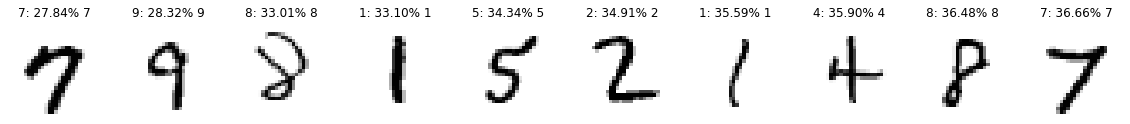

In [12]:
i_w = {k: v for k, v in sorted(wrongs.items(), key=lambda item: item[1])}

plt.figure(figsize=(20, 20))
count = 0
for i in list(i_w):
    if wrongs[i] < 90.0 and count < 10:
        plt.subplot(1, 10, count + 1)
        plt.imshow(-Xtest[i, :].reshape(28, 28), cmap='gray')
        title = f"{Y_classes[i]}: {wrongs[i]*100:.2f}% {Ttest[i]}"
        plt.title(title)
        plt.axis('off');
        count += 1

Creating a dictionary set of classifiers that each will train with the specified pairs of confused items.

In [13]:
def createCnets(asc_bad_pairs, device):
    ccnets = {}
    for i in asc_bad_pairs:
        ccnets.update({i: nn.ConvNet(28 * 28,
                    [28, 28], # n_hiddens_per_conv_layer
                    [10], # n_hiddens_per_fc_layer
                    10,
                    patch_size_per_conv_layer=[5, 5], stride_per_conv_layer=[2, 2], device=device)})
        ccnets[i].to(device)
    return ccnets

ccnets = createCnets(asc_bad_pairs, device)

Figuring out how to shape the data for training.

In [14]:
Xtrain_0s = Xtrain[Ttrain == 0]
print(Xtrain_0s.shape)
Xtrain_1s = Xtrain[Ttrain == 1]
print(Xtrain_1s.shape)
Xtrain_01s = np.concatenate( (Xtrain[Ttrain == 0], Xtrain[Ttrain == 1]), axis=0 )
print(Xtrain_01s.shape)
print(Xtrain_0s.shape[0] + Xtrain_1s.shape[0])



(4932, 784)
(5678, 784)
(10610, 784)
10610


Getting just the elements from the training set that were wrong. I wanted to try training on just these elements to see if it produced any meaningful classifiers, but the data set for this was too small to reliably produce a network that could classify things, which doesn't help my overall goal and doesn't help me test.

In [15]:
Xtrain_wrongs = np.array([Xtrain[x] for x in wrongs.keys()])
Ttrain_wrongs = np.array([Ttrain[x] for x in wrongs.keys()])


In [16]:
print(Xtrain_wrongs.shape)
print(Ttrain_wrongs.shape)


(173, 784)
(173,)


I'm creating a series of networks here that only discern between two elements. The idea is that it should figure out if something is one element or the other more reliably than the full neural network because it only trains on those specific things. When creating the convolutional training function, I added a limit on the loss so that if it was able to get to less than a certain loss number, it would stop running. This should prevent over-fitting, but also reduce the length of time it takes to train each network. Because of how complicated I've made these networks, they take a long time to train anyway, so having an early stop ensures that networks that need longer, can have longer, while networks that don't need as long can end earlier.

In [17]:

n_epochs = 1000
learning_rate = 0.001

start_time = time.time()

for i in list(asc_bad_pairs.keys()):
    print(i)
    # subnetXtr = np.concatenate( (Xtrain_wrongs[Ttrain_wrongs == i[0]], Xtrain_wrongs[Ttrain_wrongs == i[1]]), axis=0 )
    # subnetTtr = np.concatenate( (Ttrain_wrongs[Ttrain_wrongs == i[0]], Ttrain_wrongs[Ttrain_wrongs == i[1]]), axis=0 )
    subnetXtr = np.concatenate( (Xtrain[Ttrain == i[0]], Xtrain[Ttrain == i[1]]), axis=0 )
    subnetTtr = np.concatenate( (Ttrain[Ttrain == i[0]], Ttrain[Ttrain == i[1]]), axis=0 )
    subnetXtr_cnn = subnetXtr.reshape(-1, 1, 28, 28)
    subnetTtr[subnetTtr == i[0]] = 0
    subnetTtr[subnetTtr == i[1]] = 1
    ccnets[i].train(subnetXtr_cnn, subnetTtr, subnetXtr.shape[0] // 10 if subnetXtr.shape[0] > 10 else subnetXtr.shape[0], n_epochs, learning_rate, method='adam', stop_error=0.0049)

elapsed_time = time.time() - start_time

print(f'Took {elapsed_time/60:0.2f} minutes to train all of the smaller networks')


(8, 9)
adam: Epoch 100 Loss 0.046
adam: Epoch 200 Loss 0.012
adam: Epoch 300 Loss 0.006
adam: Epoch 325 Loss 0.005
(2, 5)
adam: Epoch 100 Loss 0.038
adam: Epoch 200 Loss 0.012
adam: Epoch 300 Loss 0.005
adam: Epoch 309 Loss 0.005
(2, 6)
adam: Epoch 100 Loss 0.040
adam: Epoch 200 Loss 0.011
adam: Epoch 300 Loss 0.005
adam: Epoch 302 Loss 0.005
(0, 2)
adam: Epoch 100 Loss 0.031
adam: Epoch 200 Loss 0.009
adam: Epoch 268 Loss 0.005
(5, 7)
adam: Epoch 100 Loss 0.028
adam: Epoch 200 Loss 0.008
adam: Epoch 252 Loss 0.005
(6, 8)
adam: Epoch 100 Loss 0.043
adam: Epoch 200 Loss 0.011
adam: Epoch 294 Loss 0.005
(3, 4)
adam: Epoch 100 Loss 0.027
adam: Epoch 200 Loss 0.008
adam: Epoch 261 Loss 0.005
(0, 7)
adam: Epoch 100 Loss 0.028
adam: Epoch 200 Loss 0.008
adam: Epoch 258 Loss 0.005
(0, 4)
adam: Epoch 100 Loss 0.043
adam: Epoch 200 Loss 0.013
adam: Epoch 300 Loss 0.006
adam: Epoch 332 Loss 0.005
(1, 4)
adam: Epoch 100 Loss 0.046
adam: Epoch 200 Loss 0.014
adam: Epoch 300 Loss 0.007
adam: Epoch 

In [18]:
print(list(asc_bad_pairs.keys()))

[(8, 9), (2, 5), (2, 6), (0, 2), (5, 7), (6, 8), (3, 4), (0, 7), (0, 4), (1, 4), (4, 8), (0, 8), (1, 6), (4, 5), (0, 3), (1, 9), (1, 3), (4, 7), (7, 8), (0, 5), (3, 8), (1, 8), (5, 9), (4, 6), (0, 6), (0, 9), (5, 8), (2, 7), (2, 8), (3, 7), (1, 7), (1, 2), (3, 9), (5, 6), (3, 5), (7, 9), (2, 3), (4, 9)]


Using the test data to see if the networks trained on the training data perform as expected.

In [19]:
Xtest_bad_pair = np.concatenate( (Xtest[Ttest == 4], Xtest[Ttest == 9]), axis=0 )
Ttest_bad_pair = np.concatenate( (Ttest[Ttest == 4], Ttest[Ttest == 9]), axis=0 )
Xtest_bad_pair_cnn = Xtest_bad_pair.reshape(-1, 1, 28, 28)
print(Xtest_bad_pair_cnn.shape)

(1991, 1, 28, 28)


In [20]:
testNet = ccnets[(4,9)]
print(testNet)

ConvNet(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 28, kernel_size=(5, 5), stride=(2, 2))
    (1): Conv2d(28, 28, kernel_size=(5, 5), stride=(2, 2))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=448, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
)


Because of the way the networks work, they return classifications based on which element, not on the value of the elements, so I have to convert them from element 0 and 1 back to the correct identifier. This isn't a problem in the MNIST data set but will likely be an issue in other data sets that have string labels instead of numerical labels.

In [21]:
fournine_classes, fournine_probs = testNet.use(Xtest_bad_pair_cnn)

fournine_classes[fournine_classes == 0] = 4
fournine_classes[fournine_classes == 1] = 9

This is a really weird result. It correctly identifies 4s as 4s 99ish% of the time and 9s as 9s 99ish% of the time. The whole point of this is to correctly discern between them and it makes me wonder.

In [22]:
confusion_matrix(fournine_classes, Ttest_bad_pair).style.background_gradient(cmap='Blues').format("{:.1f} %")

,4,9
4,99.2 %,0.8 %
9,0.9 %,99.1 %


In [23]:
print(Y_classes[Y_classes == 4].shape)

(976,)


In [24]:
confusion_matrix(Y_classes, Ttest).style.background_gradient(cmap='Blues').format("{:.1f} %")

,0,1,2,3,4,5,6,7,8,9
0,98.5 %,0.0 %,0.4 %,0.0 %,0.3 %,0.0 %,0.2 %,0.2 %,0.2 %,0.2 %
1,0.0 %,99.1 %,0.3 %,0.1 %,0.0 %,0.1 %,0.0 %,0.1 %,0.4 %,0.0 %
2,0.3 %,0.2 %,98.4 %,0.2 %,0.1 %,0.0 %,0.0 %,0.3 %,0.5 %,0.0 %
3,0.0 %,0.0 %,0.3 %,98.2 %,0.0 %,0.4 %,0.0 %,0.4 %,0.7 %,0.0 %
4,0.0 %,0.0 %,0.1 %,0.1 %,98.0 %,0.0 %,0.4 %,0.0 %,0.0 %,1.4 %
5,0.3 %,0.0 %,0.0 %,1.6 %,0.0 %,96.0 %,0.2 %,0.1 %,1.0 %,0.8 %
6,0.3 %,0.1 %,0.2 %,0.0 %,0.5 %,1.0 %,97.4 %,0.0 %,0.4 %,0.0 %
7,0.1 %,0.3 %,1.0 %,0.8 %,0.0 %,0.0 %,0.0 %,96.8 %,0.2 %,0.9 %
8,0.6 %,0.0 %,0.3 %,0.3 %,0.2 %,0.3 %,0.0 %,0.5 %,97.6 %,0.1 %
9,0.4 %,0.2 %,0.0 %,1.1 %,0.3 %,0.4 %,0.0 %,0.5 %,0.3 %,96.8 %


The following setup seems to just double down on whatever the original network did. Except for 1s, it doesn't actually have any difference and the point isn't to relabel 1s, specifically, but to relable everything that commonly gets mislabeled. I don't think voting is the way to go to get improvement.

In [25]:
# ```
def checkMistakes(Xtest, Y_classes, test_num):
    def castVote(vote, ballot):
        if vote in ballot:
            ballot.update({vote: ballot[vote]+1})
        else:
            ballot.setdefault(vote, 1)
        return ballot

    check_test = Xtest[Y_classes == test_num]
    Ys_check = Y_classes[Y_classes == test_num]
    check_test_cnn = check_test.reshape(-1, 1, 28, 28)
    votes = [{} for i in range(Ys_check.shape[0])]
    for i in list(asc_bad_pairs.keys()):
        if test_num in i:
            classification, _ = ccnets[i].use(check_test_cnn)
            classification[classification == 0] = i[0]
            classification[classification == 1] = i[1]
            for index in range(Ys_check.shape[0]):
                castVote(classification[index], votes[index])
    the_vote = np.array([ max(votes[i], key=votes[i].get) for i in range(len(votes))])
    # print(Ys_check)
    print(len(Ys_check[Ys_check != the_vote]))
    # print(the_vote)
    return Y_classes

In [26]:
# ```
for a in range(10):
    copy_Y_classes = copy.deepcopy(Y_classes)
    # print(f"{a}: ")
    checkMistakes(Xtest, Y_classes, a)
    # print(len(copy_Y_classes[copy_Y_classes != Y_classes]))

0
1133
0
0
0
0
0
0
0
0


In [27]:
confusion_matrix(Y_classes, Ttest).style.background_gradient(cmap='Blues').format("{:.1f} %")

,0,1,2,3,4,5,6,7,8,9
0,98.5 %,0.0 %,0.4 %,0.0 %,0.3 %,0.0 %,0.2 %,0.2 %,0.2 %,0.2 %
1,0.0 %,99.1 %,0.3 %,0.1 %,0.0 %,0.1 %,0.0 %,0.1 %,0.4 %,0.0 %
2,0.3 %,0.2 %,98.4 %,0.2 %,0.1 %,0.0 %,0.0 %,0.3 %,0.5 %,0.0 %
3,0.0 %,0.0 %,0.3 %,98.2 %,0.0 %,0.4 %,0.0 %,0.4 %,0.7 %,0.0 %
4,0.0 %,0.0 %,0.1 %,0.1 %,98.0 %,0.0 %,0.4 %,0.0 %,0.0 %,1.4 %
5,0.3 %,0.0 %,0.0 %,1.6 %,0.0 %,96.0 %,0.2 %,0.1 %,1.0 %,0.8 %
6,0.3 %,0.1 %,0.2 %,0.0 %,0.5 %,1.0 %,97.4 %,0.0 %,0.4 %,0.0 %
7,0.1 %,0.3 %,1.0 %,0.8 %,0.0 %,0.0 %,0.0 %,96.8 %,0.2 %,0.9 %
8,0.6 %,0.0 %,0.3 %,0.3 %,0.2 %,0.3 %,0.0 %,0.5 %,97.6 %,0.1 %
9,0.4 %,0.2 %,0.0 %,1.1 %,0.3 %,0.4 %,0.0 %,0.5 %,0.3 %,96.8 %


In [28]:
print(len(Y_classes[Y_classes != Ttest]))

228


Since that didn't work out, I'm just going to try checking for the probabilities instead of everything.

In [29]:
Y_classes, Y_probs = cnnet.use(Xtest_cnn)
confusion_matrix(Y_classes, Ttest).style.background_gradient(cmap='Blues').format("{:.1f} %")

,0,1,2,3,4,5,6,7,8,9
0,98.5 %,0.0 %,0.4 %,0.0 %,0.3 %,0.0 %,0.2 %,0.2 %,0.2 %,0.2 %
1,0.0 %,99.1 %,0.3 %,0.1 %,0.0 %,0.1 %,0.0 %,0.1 %,0.4 %,0.0 %
2,0.3 %,0.2 %,98.4 %,0.2 %,0.1 %,0.0 %,0.0 %,0.3 %,0.5 %,0.0 %
3,0.0 %,0.0 %,0.3 %,98.2 %,0.0 %,0.4 %,0.0 %,0.4 %,0.7 %,0.0 %
4,0.0 %,0.0 %,0.1 %,0.1 %,98.0 %,0.0 %,0.4 %,0.0 %,0.0 %,1.4 %
5,0.3 %,0.0 %,0.0 %,1.6 %,0.0 %,96.0 %,0.2 %,0.1 %,1.0 %,0.8 %
6,0.3 %,0.1 %,0.2 %,0.0 %,0.5 %,1.0 %,97.4 %,0.0 %,0.4 %,0.0 %
7,0.1 %,0.3 %,1.0 %,0.8 %,0.0 %,0.0 %,0.0 %,96.8 %,0.2 %,0.9 %
8,0.6 %,0.0 %,0.3 %,0.3 %,0.2 %,0.3 %,0.0 %,0.5 %,97.6 %,0.1 %
9,0.4 %,0.2 %,0.0 %,1.1 %,0.3 %,0.4 %,0.0 %,0.5 %,0.3 %,96.8 %


This checks the top two probabilities. If the top one is at less than 90%, it runs a check on the discerning networks.

In [30]:
X = Xtest
X_cnn = X.reshape(-1, 1, 28, 28)
for i in range(Y_classes.shape[0]):
    confused = np.argsort(Y_probs[i])[-2:]
    if Y_probs[i, confused[1]] < 0.9:
        confusion_check = tuplefyOrderedPair(confused[0], confused[1])
        if confusion_check in list(asc_bad_pairs.keys()):
            classification, _ = ccnets[confusion_check].use(X_cnn)
            classification[classification == 0] = confusion_check[0]
            classification[classification == 1] = confusion_check[1]
            Y_classes[i] = classification[i]
    


In [31]:
confusion_matrix(Y_classes, Ttest).style.background_gradient(cmap='Blues').format("{:.1f} %")

,0,1,2,3,4,5,6,7,8,9
0,99.2 %,0.0 %,0.1 %,0.0 %,0.1 %,0.1 %,0.1 %,0.2 %,0.2 %,0.0 %
1,0.0 %,96.1 %,0.7 %,0.8 %,0.6 %,0.0 %,0.4 %,0.6 %,0.8 %,0.0 %
2,0.3 %,0.0 %,98.8 %,0.1 %,0.2 %,0.0 %,0.0 %,0.3 %,0.3 %,0.0 %
3,0.0 %,0.0 %,0.4 %,98.5 %,0.0 %,0.4 %,0.0 %,0.3 %,0.3 %,0.1 %
4,0.0 %,0.0 %,0.1 %,0.1 %,98.5 %,0.0 %,0.4 %,0.0 %,0.1 %,0.8 %
5,0.3 %,0.0 %,0.0 %,1.0 %,0.0 %,97.6 %,0.2 %,0.1 %,0.4 %,0.2 %
6,0.3 %,0.1 %,0.1 %,0.0 %,0.2 %,0.5 %,98.4 %,0.0 %,0.3 %,0.0 %
7,0.0 %,0.0 %,0.8 %,0.8 %,0.0 %,0.0 %,0.0 %,97.7 %,0.1 %,0.7 %
8,0.4 %,0.0 %,0.1 %,0.3 %,0.2 %,0.2 %,0.0 %,0.4 %,98.0 %,0.3 %
9,0.3 %,0.0 %,0.0 %,0.5 %,1.0 %,0.3 %,0.0 %,0.4 %,0.2 %,97.3 %


This improvement is pretty marginal given the time required and it's a drop in accuracy for 1s. It seems like that might be why this technique isn't widely used: the gains are minimal while the time required is pretty big.